# Identifying Gray Matter Markers of Irritability: a machine learning approach
This notebook is designed to analyze previously processed gray matter density volumes using support vector regression.

In [1]:
from nipype.pipeline.engine import Workflow, Node, MapNode
from nipype.interfaces.utility import IdentityInterface, Function
from nipype.interfaces.io import SelectFiles, DataSink, DataGrabber
from nipype.algorithms.misc import Gunzip
from nipype.interfaces.spm.preprocess import VBMSegment, Segment
from nipype.interfaces.ants import Atropos, Registration, ApplyTransforms, N4BiasFieldCorrection
from nipype.interfaces.fsl import ApplyMask, BET
from pandas import DataFrame, Series, read_csv

# Study specific variables
study_home = '/moochie/user_data/CamachoCat/Aggregate_anats/GMD_ML'

sub_data_file = study_home + '/doc/subject_info.csv'
subject_info = read_csv(sub_data_file, index_col=0)
subjects_list = subject_info['freesurferID'].tolist()

preproc_dir = study_home + '/proc'
output_dir = study_home + '/ml_trainingset'

sample_template = study_home + '/templates/lcbd_template_1mm.nii.gz'
sample_template_brain = study_home + '/templates/lcbd_template_1mm_brain.nii.gz'
sample_template_mask = study_home + '/templates/lcbd_template_1mm_mask.nii.gz'

subject_info.describe()

,final_incl,Age_yrs,male,activity_level,anger_frustration,approach,attention_focusing,discomfort,soothability,fear,...,shyness,smiling_laughter,MAP_Temper_Loss,MAP_Noncompliance,MAP_General_Aggression,MAP_Low_Concern,factor1,factor2,factor3,factor4
count,208.000000,244.000000,244.000000,206.000000,206.000000,184.000000,206.000000,206.000000,206.000000,206.000000,...,206.000000,184.000000,196.000000,196.000000,196.000000,196.000000,184.000000,184.000000,184.000000,184.000000
mean,0.658654,7.668843,0.504098,4.647537,4.122960,4.990109,4.800259,4.117653,4.591181,3.735989,...,3.500356,5.453804,18.270408,4.019624,2.686327,2.973923,-0.008084,0.011493,0.022467,-0.004770
std,0.475305,1.898534,0.501011,0.962907,1.413879,0.881411,1.139342,1.136617,1.137126,1.271280,...,1.161658,0.803623,17.634562,3.667544,3.097868,3.244351,1.030382,1.030799,0.984087,1.013322
min,0.000000,4.041068,0.000000,2.142857,1.000000,2.500000,1.000000,1.333333,1.333333,0.833333,...,1.000000,2.666667,0.000000,0.000000,0.000000,0.000000,-2.693549,-2.172602,-2.771566,-2.480574
25%,0.000000,6.323751,0.000000,4.000000,3.166667,4.333333,4.041667,3.210000,3.670000,2.833333,...,2.666667,5.000000,5.000000,1.129870,0.320000,0.444444,-0.777663,-0.777866,-0.622771,-0.778930
50%,1.000000,7.374401,1.000000,4.714286,4.083333,5.000000,5.000000,4.166667,4.666667,3.831500,...,3.666667,5.500000,13.000000,2.882727,1.760000,2.000000,-0.087539,-0.035900,0.121852,-0.082322
75%,1.000000,8.778234,1.000000,5.290000,5.166667,5.666667,5.666667,4.833333,5.458333,4.666667,...,4.333333,6.000000,25.500000,6.305195,3.720000,4.000000,0.684327,0.718004,0.805549,0.671329
max,1.000000,12.791239,1.000000,6.714286,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,...,6.333333,7.000000,81.000000,15.429091,13.600000,15.111111,2.430133,2.286809,2.220284,2.453621


In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import warnings
from scipy import stats
warnings.filterwarnings('ignore')
sns.set(context='poster',style='white')
for variable in ['Age_yrs', 'MAP_Temper_Loss','MAP_Noncompliance','MAP_General_Aggression','MAP_Low_Concern']:
    plt.figure()
    sns.distplot(subject_info[variable],hist=True,kde=False,bins=30, color='#171C43', hist_kws={'edgecolor':'black'})
    #plt.savefig(variable+'_hist.svg')
    
for variable in ['MAP_Temper_Loss','MAP_Noncompliance','MAP_General_Aggression','MAP_Low_Concern']:
    plt.figure()
    a = sns.jointplot(subject_info['Age_yrs'],subject_info[variable],color='#171C43',
                      marginal_kws={'kde':False,'bins':30})
    a.annotate(stats.pearsonr,fontsize=12)
    #plt.savefig(variable+'_age_corr.svg')
    plt.show()


In [2]:
from sklearn.preprocessing import StandardScaler, PowerTransformer
from numpy import squeeze

## Create a conditions list for the feature set
age_labels = subject_info[['Age_yrs']].copy()
age_labels = age_labels.values
irr_labels = subject_info[['MAP_Temper_Loss','MAP_Noncompliance','MAP_General_Aggression','MAP_Low_Concern']].copy()
irr_labels = irr_labels.values

scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(age_labels)
sd_agedata = scaler.transform(age_labels)

pt = PowerTransformer()
pt.fit(irr_labels)
pt_irritability = pt.transform(irr_labels)
pt_irritability = squeeze(pt_irritability)

subject_info = subject_info.merge(DataFrame(pt_irritability,
                                            columns=['temploss_yj','noncomp_yj','genagg_yj','lowcon_yj'],
                                            index=subject_info.index),left_index=True, right_index=True)
subject_info['age_cent'] = sd_agedata

#subject_info.to_csv(output_dir + '/featureset_key.csv')
subject_info.describe()

,final_incl,Age_yrs,male,activity_level,anger_frustration,approach,attention_focusing,discomfort,soothability,fear,...,MAP_Low_Concern,factor1,factor2,factor3,factor4,temploss_yj,noncomp_yj,genagg_yj,lowcon_yj,age_cent
count,208.000000,244.000000,244.000000,206.000000,206.000000,184.000000,206.000000,206.000000,206.000000,206.000000,...,196.000000,184.000000,184.000000,184.000000,184.000000,1.960000e+02,1.960000e+02,1.960000e+02,1.960000e+02,2.440000e+02
mean,0.658654,7.668843,0.504098,4.647537,4.122960,4.990109,4.800259,4.117653,4.591181,3.735989,...,2.973923,-0.008084,0.011493,0.022467,-0.004770,-2.990805e-16,-1.178196e-16,1.087565e-16,-1.812609e-17,1.146624e-16
std,0.475305,1.898534,0.501011,0.962907,1.413879,0.881411,1.139342,1.136617,1.137126,1.271280,...,3.244351,1.030382,1.030799,0.984087,1.013322,1.002561e+00,1.002561e+00,1.002561e+00,1.002561e+00,1.002056e+00
min,0.000000,4.041068,0.000000,2.142857,1.000000,2.500000,1.000000,1.333333,1.333333,0.833333,...,0.000000,-2.693549,-2.172602,-2.771566,-2.480574,-1.980704e+00,-1.802264e+00,-1.399991e+00,-1.336606e+00,-1.914758e+00
25%,0.000000,6.323751,0.000000,4.000000,3.166667,4.333333,4.041667,3.210000,3.670000,2.833333,...,0.444444,-0.777663,-0.777866,-0.622771,-0.778930,-7.328741e-01,-7.853649e-01,-9.571042e-01,-8.457283e-01,-7.099464e-01
50%,1.000000,7.374401,1.000000,4.714286,4.083333,5.000000,5.000000,4.166667,4.666667,3.831500,...,2.000000,-0.087539,-0.035900,0.121852,-0.082322,3.652227e-02,1.841654e-02,9.826226e-02,8.370074e-02,-1.554081e-01
75%,1.000000,8.778234,1.000000,5.290000,5.166667,5.666667,5.666667,4.833333,5.458333,4.666667,...,4.000000,0.684327,0.718004,0.805549,0.671329,7.100848e-01,8.606560e-01,7.667842e-01,6.984587e-01,5.855417e-01
max,1.000000,12.791239,1.000000,6.714286,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,...,15.111111,2.430133,2.286809,2.220284,2.453621,2.142143e+00,1.935011e+00,1.944626e+00,2.005997e+00,2.703625e+00


(array([11., 12., 20., 30., 26., 35., 22., 16., 16.,  8.]),
 array([-1.98070394, -1.56841928, -1.15613462, -0.74384996, -0.3315653 ,
         0.08071936,  0.49300402,  0.90528869,  1.31757335,  1.72985801,
         2.14214267]),
 <a list of 10 Patch objects>)

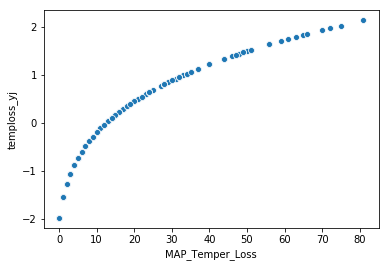

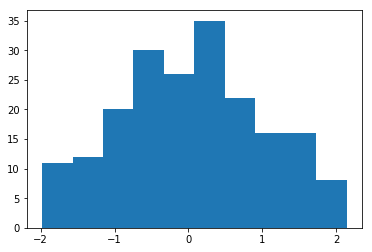

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.scatterplot(x='MAP_Temper_Loss',y='temploss_yj',data=subject_info)
plt.figure()
plt.hist(subject_info['temploss_yj'][np.isfinite(subject_info['temploss_yj'])])

In [13]:
## Concatenate all the parameter estimates from preproc to create a feature set
from glob import glob
from nipype.interfaces.fsl.utils import Merge

gm_template = preproc_dir + '/final_gmd/{0}/final_smooth_gm.nii.gz'
gm_files = []
for sub in subjects_list:
    gm_files.append(gm_template.format(sub))
gmd_feature_data = output_dir + '/gmd_combined.nii.gz'
#print(gm_files)
merge = Merge()
merge.inputs.in_files = gm_files
merge.inputs.dimension = 't'
merge.inputs.merged_file = gmd_feature_data
#merge.run()

In [28]:
from nilearn.input_data import NiftiMasker

analysis = 'factor4'
masker = NiftiMasker(mask_img=sample_template_mask,standardize=True, 
                     memory='nilearn_cache', memory_level=1)
X = masker.fit_transform(gmd_feature_data)


if analysis == 'Age':
    mask = subject_info['final_incl']==1
    labels = subject_info['age_cent'][mask]
    groups = subject_info['freesurferID'][mask]
    X=X[mask]
elif analysis == 'Temper_Loss':
    mask = (subject_info['MAP_Temper_Loss']>=0) & (subject_info['final_incl']==1)
    labels = subject_info['temploss_yj'][mask]
    groups = subject_info['freesurferID'][mask]
    X = X[mask]
elif analysis == 'Noncompliance':
    mask = (subject_info['MAP_Noncompliance']>=0) & (subject_info['final_incl']==1)
    labels = subject_info['noncomp_yj'][mask]
    groups = subject_info['freesurferID'][mask]
    X = X[mask]
elif analysis == 'General_Aggression':
    mask = (subject_info['MAP_General_Aggression']>=0) & (subject_info['final_incl']==1)
    labels = subject_info['genagg_yj'][mask]
    groups = subject_info['freesurferID'][mask]
    X = X[mask]
elif analysis == 'Low_Concern':
    mask = (subject_info['MAP_Low_Concern']>=0) & (subject_info['final_incl']==1)
    labels = subject_info['lowcon_yj'][mask]
    groups = subject_info['freesurferID'][mask]
    X = X[mask]
elif analysis == 'factor1':
    mask = (subject_info['smiling_laughter']>=0) & (subject_info['final_incl']==1)
    labels = subject_info['factor1'][mask]
    groups = subject_info['freesurferID'][mask]
    X = X[mask]
elif analysis == 'factor2':
    mask = (subject_info['smiling_laughter']>=0) & (subject_info['final_incl']==1)
    labels = subject_info['factor2'][mask]
    groups = subject_info['freesurferID'][mask]
    X = X[mask]
elif analysis == 'factor3':
    mask = (subject_info['smiling_laughter']>=0) & (subject_info['final_incl']==1)
    labels = subject_info['factor3'][mask]
    groups = subject_info['freesurferID'][mask]
    X = X[mask]
elif analysis == 'factor4':
    mask = (subject_info['smiling_laughter']>=0) & (subject_info['final_incl']==1)
    labels = subject_info['factor4'][mask]
    groups = subject_info['freesurferID'][mask]
    X = X[mask]
    
results_file = open(output_dir + '/results_' + analysis + '.txt','w')
labels.describe()

count    123.000000
mean      -0.048639
std        1.058680
min       -2.771566
25%       -0.681212
50%        0.009125
75%        0.828471
max        2.220284
Name: factor3, dtype: float64

/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:293: RuntimeWarning: invalid value encountered in sqrt
  n_samples * X_means ** 2)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.5/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.5/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value e

prediction accuracy: 0.2731 / p-value: 0.002239 / MSE: 1.032512 // Spearman: 0.285660 / p-value: 0.001361


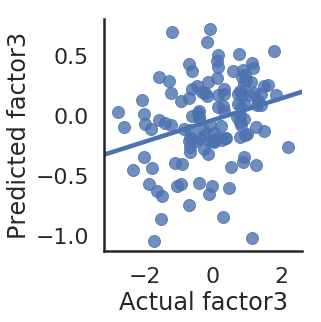

In [29]:
# Perform the support vector classification
from nilearn.input_data import NiftiMasker
from sklearn.feature_selection import f_regression, SelectPercentile
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from pandas import DataFrame, Series

# Set up the regression
svr = SVR(kernel='linear', C=1)

feature_selection = SelectPercentile(f_regression, percentile=5)
fs_svr = Pipeline([('feat_select', feature_selection), ('svr', svr)])

# Run the regression
fs_svr.fit(X, labels)

from sklearn.model_selection import cross_val_predict, LeaveOneGroupOut, RepeatedKFold

#cv = LeaveOneGroupOut()
cv = RepeatedKFold(n_splits=10,n_repeats=10)
y_pred = cross_val_predict(fs_svr, X, y=labels, n_jobs=20,groups=groups,cv=10)

# save weights
coef = svr.coef_
coef = feature_selection.inverse_transform(coef)
coef_image = masker.inverse_transform(coef)
coef_image.to_filename(output_dir + '/svrweights_' + analysis + '.nii.gz')

from scipy.stats import linregress
slope, intercept, r_val, p_val, stderr = linregress(labels, y_pred) 

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(labels, y_pred)

from scipy.stats import spearmanr
spear_r, spear_p = spearmanr(labels, y_pred)

print("prediction accuracy: %.4f / p-value: %f / MSE: %f // Spearman: %f / p-value: %f" % (r_val, p_val, mse, spear_r, spear_p))

svr_results=DataFrame()
svr_results['labels']=labels
svr_results['y_pred']=Series(y_pred,index=labels.index)
# plot the predicted versus actual values
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='poster',style='white')
sns.lmplot(x='labels', y='y_pred',ci=None,data=svr_results)
plt.xlabel('Actual ' + analysis)
plt.ylabel('Predicted ' + analysis)
plt.savefig(output_dir + '/scatter_pred_actual_' + analysis + '_poster.svg')
plt.show()
plt.close()

results_file.write("Prediction accuracy r-value: %.4f / p-value: %f / MSE: %f // Spearman: %f / p-value: %f \n" % (r_val, p_val, mse, spear_r, spear_p))
results_file.write('predicted: ' + str(y_pred) + '\n')
results_file.write('actual: ' + str(labels) + '\n')

results_file.close()

In [ ]:
from sklearn.model_selection import permutation_test_score
import matplotlib.pyplot as plt
from numpy import savetxt

results_file = open(output_dir + '/perm_results_' + analysis + '.txt','w')

score, permutation_scores, pvalue = permutation_test_score(fs_svr, X, labels, scoring='neg_mean_squared_error', 
                                                           cv=cv, n_permutations=500, n_jobs=20, groups=groups)
savetxt(output_dir + '/permutation_scores_mse_' + analysis + '.txt', permutation_scores)

# Save a figure of the permutation scores
plt.hist(permutation_scores, 20, label='Permutation scores',
         edgecolor='black')
ylim = plt.ylim()
plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Mean Squared Error (pvalue %f)' % pvalue)
plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.savefig(output_dir + '/permutation_plot_mse_' + analysis + '.svg', transparent=True)
plt.close()

# save final pval/classifier score
results_file.write('MSE score %s (pvalue : %s) \n' % (score, pvalue))

## Perform permutation testing to get a p-value for r-squared
score, permutation_scores, pvalue = permutation_test_score(fs_svr, X, labels, scoring='r2', 
                                                           cv=cv, n_permutations=500, n_jobs=20, groups=groups)
savetxt(output_dir + '/permutation_scores_r2_' + analysis + '.txt', permutation_scores)

# Save a figure of the permutation scores
plt.hist(permutation_scores, 20, label='Permutation scores',
         edgecolor='black')
ylim = plt.ylim()
plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='R-squared (pvalue %f)' % pvalue)
plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.savefig(output_dir + '/permutation_plot_r2_' + analysis + '.svg', transparent=True)
plt.close()

# save final pval/classifier score
results_file.write('R square: %s (pvalue : %s) \n' % (score, pvalue))
results_file.close()

In [ ]:
from nilearn.input_data import NiftiMasker

analysis = 'sequence_LOSO_6_10'
masker = NiftiMasker(mask_img=sample_template_mask,standardize=True, 
                     memory='nilearn_cache', memory_level=1)
X = masker.fit_transform(gmd_feature_data)
mask=(conditions.age_yrs<=10) & (conditions.age_yrs>=6)

if analysis == 'sequence_LOSO':
    labels = conditions['sequence']
    groups = conditions['subject'] 
elif analysis == 'sequence_LOGO':
    labels = conditions['sequence']
    groups = conditions['sequence'] 
elif analysis == 'sequence_LOSO_6_10':
    labels = conditions['sequence'][mask]
    groups = conditions['subject'][mask]
    X=X[mask]

    
results_file = open(output_dir + '/results_' + analysis + '.txt','w')
labels.describe()

In [ ]:
# Perform the support vector classification
from sklearn.svm import SVC
from sklearn.feature_selection import f_classif, SelectPercentile
from sklearn.pipeline import Pipeline

# Set up the support vector classifier
svc = SVC(kernel='linear')

# Select the features contributing to the model
feature_selection = SelectPercentile(f_classif, percentile=5) #0.05/228453 voxels
fs_svc = Pipeline([('feat_select', feature_selection), ('svc', svc)])

# Run the classifier
fs_svc.fit(X, labels)

# Obtain prediction values via cross validation
from sklearn.model_selection import cross_validate, LeaveOneGroupOut, cross_val_predict

loso = LeaveOneGroupOut()
cv_scores = cross_validate(fs_svc, X, y=labels, n_jobs=20, return_train_score=True,
                           groups=groups, cv=loso, scoring='accuracy')
y_pred = cross_val_predict(fs_svc, X, y=labels, n_jobs=20,groups=groups, cv=loso)

## Save the SVM weights to a nifti
coef = svc.coef_
coef = feature_selection.inverse_transform(coef)
weight_img = masker.inverse_transform(coef)
weight_img.to_filename(output_dir + '/svmweights_'+ analysis +'.nii.gz')

## Calculate performance metrics
from sklearn.metrics import recall_score, precision_score

classification_accuracy = cv_scores['test_score'].mean()
chance = 1. / len(labels.unique())
print("Classification accuracy: %.4f / Chance level: %f" % 
      (classification_accuracy, chance))

for label in labels.unique():
    sensitivity = recall_score(labels,y_pred,labels=[label],average='weighted')
    precision = precision_score(labels,y_pred,labels=[label],average='weighted')

    results_file.write("%s: classification accuracy: %.4f \n chance level: %f \n sensitivity: %f \n precision: %f \n" % 
    (label, classification_accuracy, chance, sensitivity, precision))

# compute and display a confusion matrix
from sklearn.metrics import confusion_matrix
from numpy import set_printoptions
import itertools
import matplotlib.pyplot as plt

cnf_matrix = confusion_matrix(labels, y_pred)
set_printoptions(precision=2)
classes = labels.unique()

def plot_confusion_matrix(cm, classes):
    from numpy import arange
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=16)
    plt.yticks(tick_marks, classes, size=16)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j],  'd'),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black', size=16)

    plt.tight_layout()
    plt.ylabel('True label', size=16)
    plt.xlabel('Predicted label', size=16)

plot_confusion_matrix(cnf_matrix, classes)
plt.savefig(output_dir + '/confusion_matrix_' + analysis + '.svg', transparent=True)
plt.close()

results_file.close()